In [1]:
%matplotlib ipympl
import matplotlib.pyplot as plt
from ows import fouriertransform as mathft

import numpy as np
from numpy.fft import  ifft2, ifftshift
from numpy.random import default_rng as randn
#from scipy.special import kv as beselk
from ipywidgets import interact, widgets
from ows import ows
import time
from scipy import signal

rad2asec = 3600 * 180/np.pi
asec2rad = 1/rad2asec

## PSD
Power spectrum density

In [5]:
start = time.time()
# Input

dimmat = 128
dxp = 0.003222887597610881 # Pupil plane pixel size
r0 = .1
L0 = -1
D = 0.01
wl = 500e-9 # [m]

# Computing limit values
FoV = 25*asec2rad # arcsec
#Npx = 1000 # image plane pixels qty
#Daf = asec2rad*FoV#/Npx # [rad/px]  (Numerical aperture)
Daf = wl/(2*D) # max
dfp = Daf/wl # [/m] Pupil plane spatial frequency pixel size (Numerical aperture/WL)
dimpsf = 8*wl*np.sqrt((D/r0)**2 + 1)/(Daf*D)   # (min psf size) Matrix size
print("Miminum matrix dimention :",dimpsf)
# dimmat = int(dimpsf)+int((dimpsf %1 !=0)*1)
# dimmat += int((dimmat %2 != 0)*1)

if dimmat < dimpsf:
    print(f"dimmat is too small: {dimmat:d}. It souhld be greater than {dimpsf:.1f}")


PSD = ows.psd(dimmat, dxp, r0, wl)
# plt.close(1)
# plt.figure(1)
# plt.imshow(PSD**(1/8))
# plt.title("Phase spectrum density ^(1/8)")
# plt.colorbar()

Miminum matrix dimention : 16.079800993793423


## Phase screen & PSF

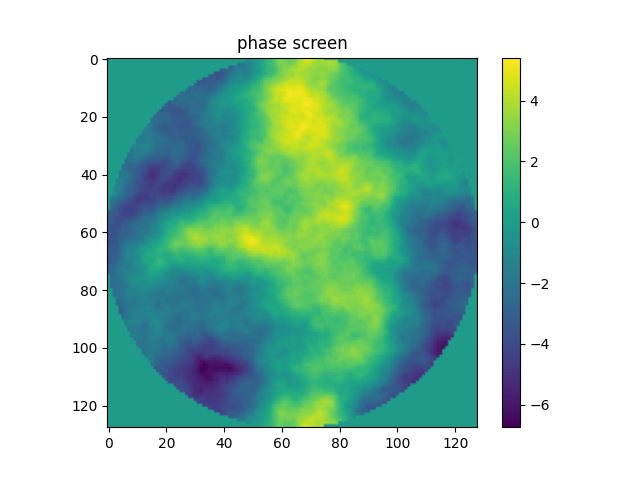

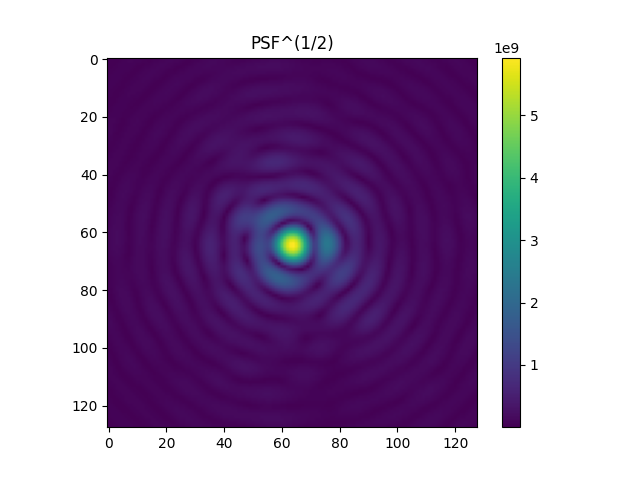

In [6]:
SEED = 1

[phase_screen, psf, pupil_mask, R] = ows.phase_screen(PSD, dxp, SEED, PUPIL = True)


plt.close(4)
plt.figure(4)
plt.imshow(phase_screen.real)
plt.title("phase screen")
plt.colorbar()

plt.show()
plt.close(5)
plt.figure(5)
plt.imshow((np.abs(psf)**(1/2)))
plt.title("PSF^(1/2)")
plt.colorbar()
plt.show()


# Long exposure PSF

C:\Users\dominiqu.humbert\AppData\Local\Temp\ipykernel_4700\786446381.py:13: RuntimeWarning: invalid value encountered in power
  term2 = (x ** (5/6)) * kv(5/6, x)
C:\Users\dominiqu.humbert\AppData\Local\Temp\ipykernel_4700\786446381.py:13: RuntimeWarning: invalid value encountered in multiply
  term2 = (x ** (5/6)) * kv(5/6, x)


TypeError: Image data of dtype complex128 cannot be converted to float

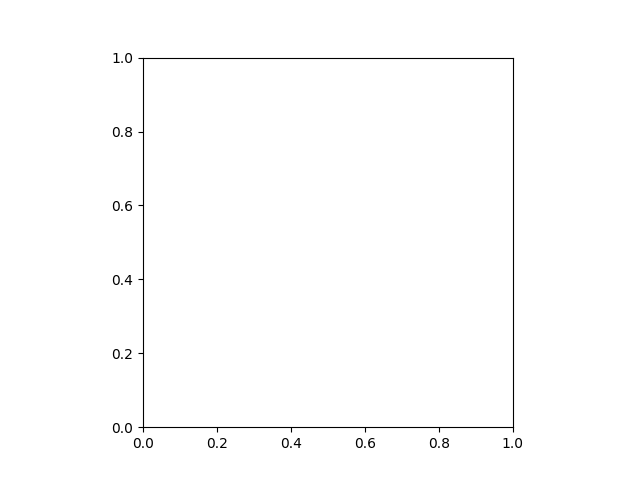

In [4]:
from scipy.special import gamma, kv

def telescope_otf(nu_n, epsilon):
    otf = np.zeros_like(nu_n)
    mask = nu_n <= 1
    otf[mask] = (2 / np.pi) * (np.arccos(nu_n[mask]) - nu_n[mask] * np.sqrt(1 - nu_n[mask]**2))
    return otf

def D_phi(rho):
        alpha = 0.17166136
        term1 = 1.0056349
        x = 2 * np.pi * rho / L0
        term2 = (x ** (5/6)) * kv(5/6, x)
        return alpha * (L0 / r0) ** (5/3) * (term1 - term2)

nu = np.fft.fftfreq(dimmat, d=dxp)
nu_x, nu_y = np.meshgrid(nu, nu)
nu_r = np.sqrt(nu_x**2 + nu_y**2)
nu_n = nu_r * wl / D
rho = wl * nu_r
plt.close(1)
plt.figure(1)
plt.imshow(D_phi(rho))
plt.show()

# Lenslet illumination mask

# Lenslet array illumination

# SHWFS

## 1. Lenslet illumination mask
-
## 2. Lenslet array illumination
Lenslet with coverage $\geq$ 50\% are considered.

## 3. Wavefront slope


Focal plane image:
$$U_f= \frac{1}{i\lambda F}\mathcal{F}\{t_p(x,y)\}$$

where $t_p(x,y)$ is the object (the phase screen in this case)


???

2. Compute the spot centers

$$x_{c,k} = \frac{\sum_{i\in k}\sum_{j\in k} x_{i,j}I_{i,j}}{\sum_{i\in k}\sum_{j\in k} I_{i,j}}$$

$$y_{c,k} = \frac{\sum_{i\in k}\sum_{j \in k} y_{i,j}I_{i,j}}{\sum_{i\in k}\sum_{j\in k} I_{i,j}}$$

3. Extract the WF slopes

$$ \begin{bmatrix}\partial w /\partial x \\ \partial w/\partial y\end{bmatrix}_k = \begin{bmatrix} \beta_x\\\beta_y \end{bmatrix}_k \approx \frac{1}{L_H}\begin{bmatrix} x_c - x_r\\y_c - y_r \end{bmatrix}_k$$


In [ ]:
from ows import fouriertransform as mathft

### 1. focussing the sub-apetures + aperture centres
F = 8e-3 #[m]
N = 18



[lightfield, DwDx, DyDx] = ows.SHWFS(dimmat, N, F, wl, pupil_mask, R, phase_screen, dxp, lenslet_pad=4)




end = time.time()

print("Processingtime :",
      (end-start) * 10**3, "ms")

lightfield = normalize(lightfield)

plt.close(8)
plt.figure(8)
plt.imshow(lightfield)
plt.title("padded lightfield")
plt.show()

# plt.close(9)
# plt.figure(9)
# plt.subplot(1,2,1)
# plt.imshow(DwDx)
# plt.title("Dw/Dx")
# plt.subplot(1,2,2)
# plt.imshow(DwDy)
# plt.title("Dw/Dy")
# plt.show()



# Saves

In [ ]:
from astropy.io import fits

def normalize(data):
    min_val = np.min(data)
    max_val = np.max(data)
    return (data - min_val) / (max_val - min_val)

# phase_screen_normilized = normalize(phase_screen)
# psf_normalized = normalize(psf)

# fits.writeto('data/phase_screen.fits', phase_screen, overwrite=True)
# fits.writeto('data/phase_screen_normalized.fits', phase_screen_normilized, overwrite=True)
# fits.writeto('data/psf.fits', psf, overwrite=True)
# fits.writeto('data/psf_normalized.fits', psf_normalized, overwrite=True)

# input_infos = f"ro,{r0:f},m\nWL,{wl:g},m\ndxp,{dxp:f},\nseed,{1},"
# with open('data/inputs.txt', 'w') as f:
#     f.write(input_infos)